Well, it has been a few months and I'm still over here trying to figure out how to work with topic models. Deceptively simple things to create ... harder to work through post-processing techniques that I can explain and defend.

In the first set of posts, I used the [Gensim](https://radimrehurek.com/gensim/) library to create the models. Gensim offered a number of advantages - it is written in Python, so it plays nicely with the rest of my programming ecosystem; it relies on streaming the documents, so it didn't overwhelm my hard drive. It does have its downsides, though. For one, the community of users in the digital humanities is much smaller, which means that there are fewer discussion and examples around how to use the Gensim output. In addition, the process of streaming documents looses some of the nuance that libraries which load the whole corpus into memory, such as Mallet, are able to achieve. So, in the end, I have acquiesced to community wisdom and have switched to the easier to use data exports of Mallet, using Digital Ocean "droplets" to create the models without overwhelming my laptop.

Evaluating the quality of the models is, as it has been described by others, a bit of an exercise in "reading tea leaves."^[] My initial approach has been interpretive, reading the topics for their internal coherence, the match between the topic and the documents they describe, and my ability to label those topics coherently. Working with a 300 topic model of the entire corpus, about half way through this exercise, I developed a growing sense that there was too much overlap between the topics. But this is digital history! Intuition doesn't seem like quite enough of a reason to dismiss a model as having too many topics - there should be a way to use numbers to do that.

Thankfully, I am not the first to this problem, and computing correlations between topics is part of the process that others have used to visualize their models as networks, or to use principle component analysis to position the topics relative to one another in space. 

In [105]:
import gzip
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.preprocessing
import sklearn.metrics

In [2]:
%matplotlib inline 

In [3]:
dataDir = "../../data/"

In [115]:
def extract_params(statefile):
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf8').strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(":")[1].split(" ")), float(params[1].split(":")[1]))

def state_to_df(statefile):
    return pd.read_csv(statefile,
                       compression='gzip',
                       sep=' ',
                       skiprows=[1,2]
                       )

def get_topic_keys(keyfile):
    df = pd.read_csv(keyfile, sep='\t', header=None)
    return df.rename(columns = {0:'topic', 1: 'overallWeight', 2: 'topic_words'})

In [11]:
params = extract_params(os.path.join(dataDir, 'modelSet-state.gz'))

In [12]:
df = state_to_df(os.path.join(dataDir, 'modelSet-state.gz'))

To turn this into a tw matrix, i need all the topics as columns, all the words as rows, and the weight to be the count of the word occurrences in the topics. We then smooth this by adding the value of beta to all, and the normalize on the row (so that sums to 1). 

+ https://cran.r-project.org/web/packages/mallet/mallet.pdf
+ https://github.com/agoldst/dfrtopics/blob/43362fd4aea25caedf59f610fb02f3aaa30334ca/R/matrices.R

Correlation is a little tricky.

words/topics or documents/topics 
When using documents, measuring topics that tend to be used together. When using words, tracking if words are consistently assigned to two topics

In [14]:
wt = df[['type', 'topic']]

In [15]:
wt

,type,topic
0,draining,38
1,advocate,262
2,december,163
3,heavenly,37
4,visitor,37
5,waiting,37
6,lord,37
7,good,172
8,cause,172
9,holy,163


In [25]:
def aggregate_data(df, topic_col='topic', word_col='type'):
    df = df.groupby([topic_col, word_col]).agg({word_col: {'count': lambda x: x.count()}})
    df.columns = df.columns.droplevel(0)
    
    return df.reset_index()

def pivot_and_smooth(df, beta, rows='type', cols='topic'):
    matrix = df.pivot(index=rows, columns=cols, values='count').fillna(value=0)
    matrix = matrix + beta
    
    return pd.DataFrame(sklearn.preprocessing.normalize(matrix, norm='l1', axis=0))

def graph_matrix(matrix):
    """
    Note: Negative correlations, which would indicate that the words in one topic are 
    missing from another topic, are not interesting for our purpose of measuring when topics
    overshare words. By centering at 0.5, we are focusing on positive overlap between topics.
    """
    f, ax = plt.subplots(figsize=(30,30))
    mask = np.zeros_like(matrix)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        sns.heatmap(matrix,
                    center = 0.5,
                    mask = mask, 
                    cmap = sns.diverging_palette(220, 10, as_cmap=True),
                    square = True,
                    xticklabels = 2,
                    cbar_kws={"label":"Correlation (Pearson) between Topics"},
                    ax = ax)

In [19]:
agg = aggregate_data(wt, 'topic', 'type')

In [21]:
matrix300 = pivot_and_smooth(agg, params[1])
matrix300

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,6.614917e-08,2.824164e-08,3.961844e-08,3.487779e-08,8.072298e-08,2.032915e-08,2.309432e-08,5.870200e-08,3.369165e-08,8.952688e-08,...,3.978760e-08,9.348095e-08,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,3.931016e-08,2.617080e-08
1,6.614917e-08,2.824164e-08,3.961844e-08,3.487779e-08,8.072298e-08,2.032915e-08,2.309432e-08,5.870200e-08,2.610681e-06,8.952688e-08,...,3.978760e-08,9.348095e-08,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,3.931016e-08,2.617080e-08
2,1.524490e-05,2.824164e-08,3.961844e-08,3.487779e-08,8.072298e-08,2.032915e-08,2.309432e-08,5.870200e-08,3.369165e-08,8.952688e-08,...,3.978760e-08,7.243602e-06,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,6.052778e-06,2.617080e-08
3,6.614917e-08,2.824164e-08,3.961844e-08,3.487779e-08,8.072298e-08,2.032915e-08,2.309432e-08,5.870200e-08,3.369165e-08,8.952688e-08,...,3.978760e-08,9.348095e-08,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,3.931016e-08,2.617080e-08
4,6.614917e-08,2.824164e-08,3.961844e-08,3.487779e-08,8.072298e-08,2.032915e-08,2.309432e-08,5.870200e-08,3.369165e-08,8.952688e-08,...,3.978760e-08,9.348095e-08,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,3.931016e-08,2.617080e-08
5,6.614917e-08,2.824164e-08,3.961844e-08,3.487779e-08,8.072298e-08,2.032915e-08,2.309432e-08,4.548669e-06,3.369165e-08,8.952688e-08,...,3.978760e-08,9.348095e-08,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,3.931016e-08,2.617080e-08
6,6.614917e-08,2.824164e-08,3.961844e-08,2.702592e-06,1.242932e-05,2.032915e-08,2.309432e-08,5.870200e-08,3.369165e-08,8.952688e-08,...,3.978760e-08,9.348095e-08,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,3.931016e-08,2.617080e-08
7,6.614917e-08,2.824164e-08,3.961844e-08,3.487779e-08,8.072298e-08,2.032915e-08,2.309432e-08,5.870200e-08,3.369165e-08,8.952688e-08,...,3.978760e-08,9.348095e-08,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,3.931016e-08,2.617080e-08
8,6.614917e-08,2.824164e-08,3.961844e-08,3.487779e-08,8.072298e-08,2.032915e-08,2.309432e-08,5.870200e-08,3.369165e-08,8.952688e-08,...,3.978760e-08,9.348095e-08,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,3.931016e-08,2.617080e-08
9,6.614917e-08,2.824164e-08,3.961844e-08,3.487779e-08,8.072298e-08,2.032915e-08,2.309432e-08,5.870200e-08,3.369165e-08,8.952688e-08,...,3.978760e-08,9.348095e-08,1.044471e-07,1.264081e-08,2.094313e-08,2.343510e-08,6.608664e-08,2.458331e-08,3.931016e-08,2.617080e-08


In [22]:
corr300 = matrix300.corr()

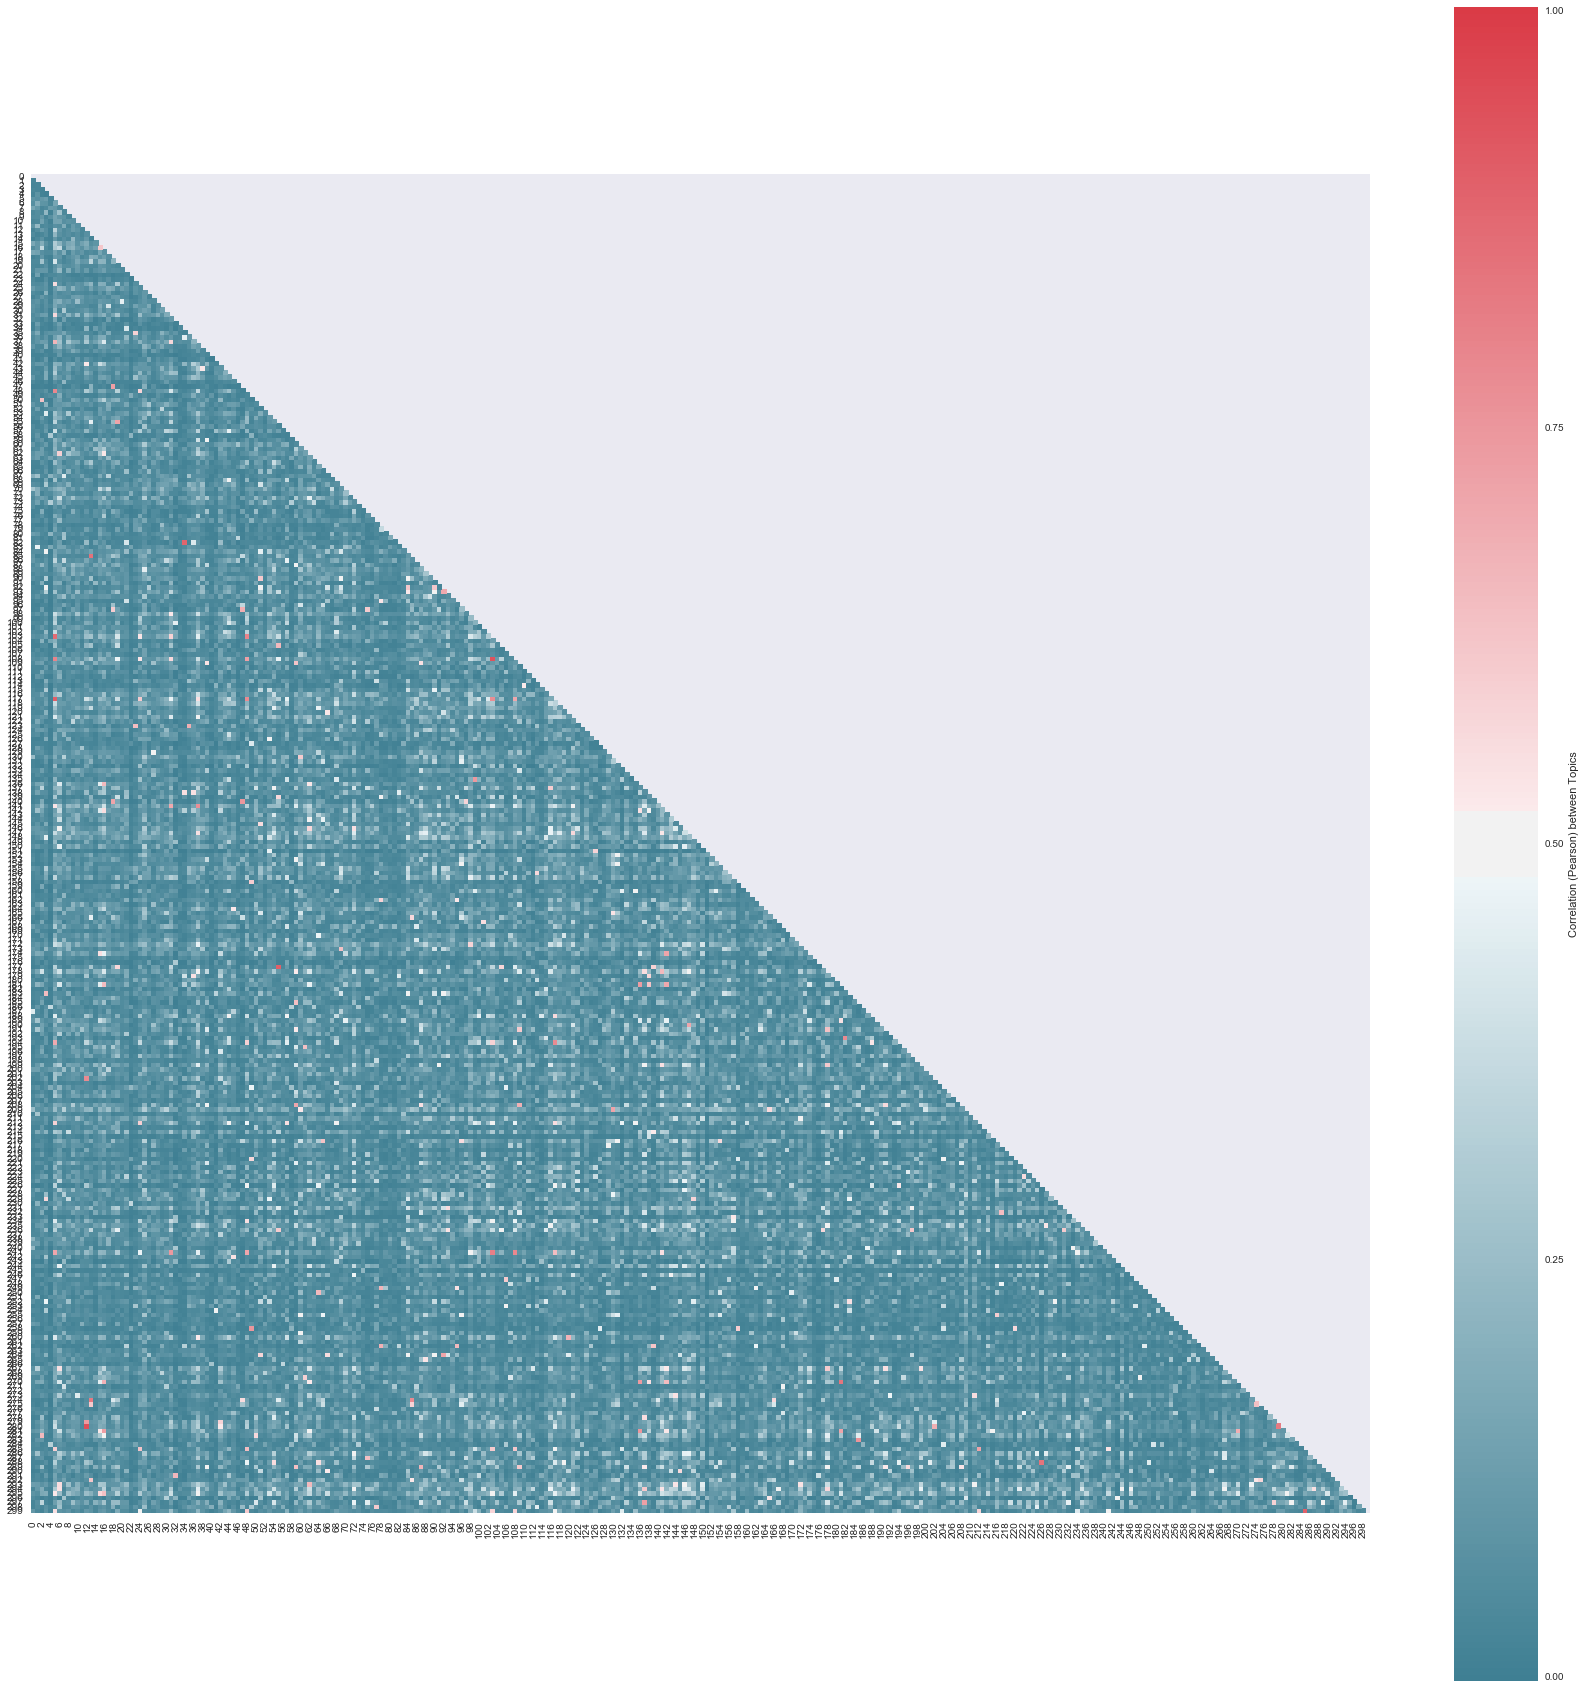

In [26]:
graph_matrix(corr300)

In [64]:
keys300 = get_topic_keys(os.path.join(dataDir, 'modelSet-topicKeys.txt')).drop('overallWeight', axis=1)
keys300

In [55]:
def get_top_pairs(matrix, n_pairs):
    df = pd.DataFrame(matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False)[:n_pairs]).reset_index()
    df = df.rename(columns = {'level_0': 'topic_1', 'level_1': 'topic_2', 0: 'correlation'})
    return df

In [69]:
topPairs300 = get_top_pairs(corr300, 50)
topPairs300

,topic_1,topic_2,correlation
0,12,280,0.943399
1,103,108,0.933791
2,5,117,0.903257
3,55,177,0.896926
4,285,299,0.896894
5,34,82,0.881015
6,5,103,0.868474
7,13,85,0.849196
8,226,288,0.845059
9,181,270,0.841522


In [71]:
def merge_frames(pairs, keys):
    merge1 = pairs.merge(keys, left_on='topic_1', right_on='topic', how='left')
    return merge1.merge(keys, left_on='topic_2', right_on='topic', how='left')

In [72]:
merge_frames(topPairs300, keys300)

,topic_1,topic_2,correlation,topic_x,topic_words_x,topic_y,topic_words_y
0,12,280,0.943399,12,born died church sister brother child writer h...,280,died church sister aged brother writer born mo...
1,103,108,0.933791,103,meeting sabbath truth church bro place held go...,108,meeting sabbath tent truth bro good church pla...
2,5,117,0.903257,5,meeting brother lord church sabbath truth plac...,117,church brother meeting sabbath elder sister he...
3,55,177,0.896926,55,sabbath seventh week sunday commandment lord c...,177,sabbath seventh lord rest holy man rested crea...
4,285,299,0.896894,285,meeting camp conference tent held ground broth...,299,meeting camp tent attend held ground conferenc...
5,34,82,0.881015,34,child mother little baby parent infant care yo...,82,child parent mother youth father home characte...
6,5,103,0.868474,5,meeting brother lord church sabbath truth plac...,103,meeting sabbath truth church bro place held go...
7,13,85,0.849196,13,sunday sabbath law church christian american u...,85,sunday law city police business store closing ...
8,226,288,0.845059,226,church member elder order organization ministe...,288,church christian baptist methodist religious p...
9,181,270,0.841522,181,little said mother boy child think mamma know ...,270,said mother girl little know aunt think dear m...


## With 250 Topics

In [73]:
params250 = extract_params(os.path.join(dataDir, 'modelSet_for_Mallet.1918.state.gz'))

In [74]:
model250 = state_to_df(os.path.join(dataDir, 'modelSet_for_Mallet.1918.state.gz'))

In [77]:
wt250 = model250[['type', 'topic']]

In [82]:
corr250 = pivot_and_smooth(aggregate_data(wt250), params250[1]).corr()

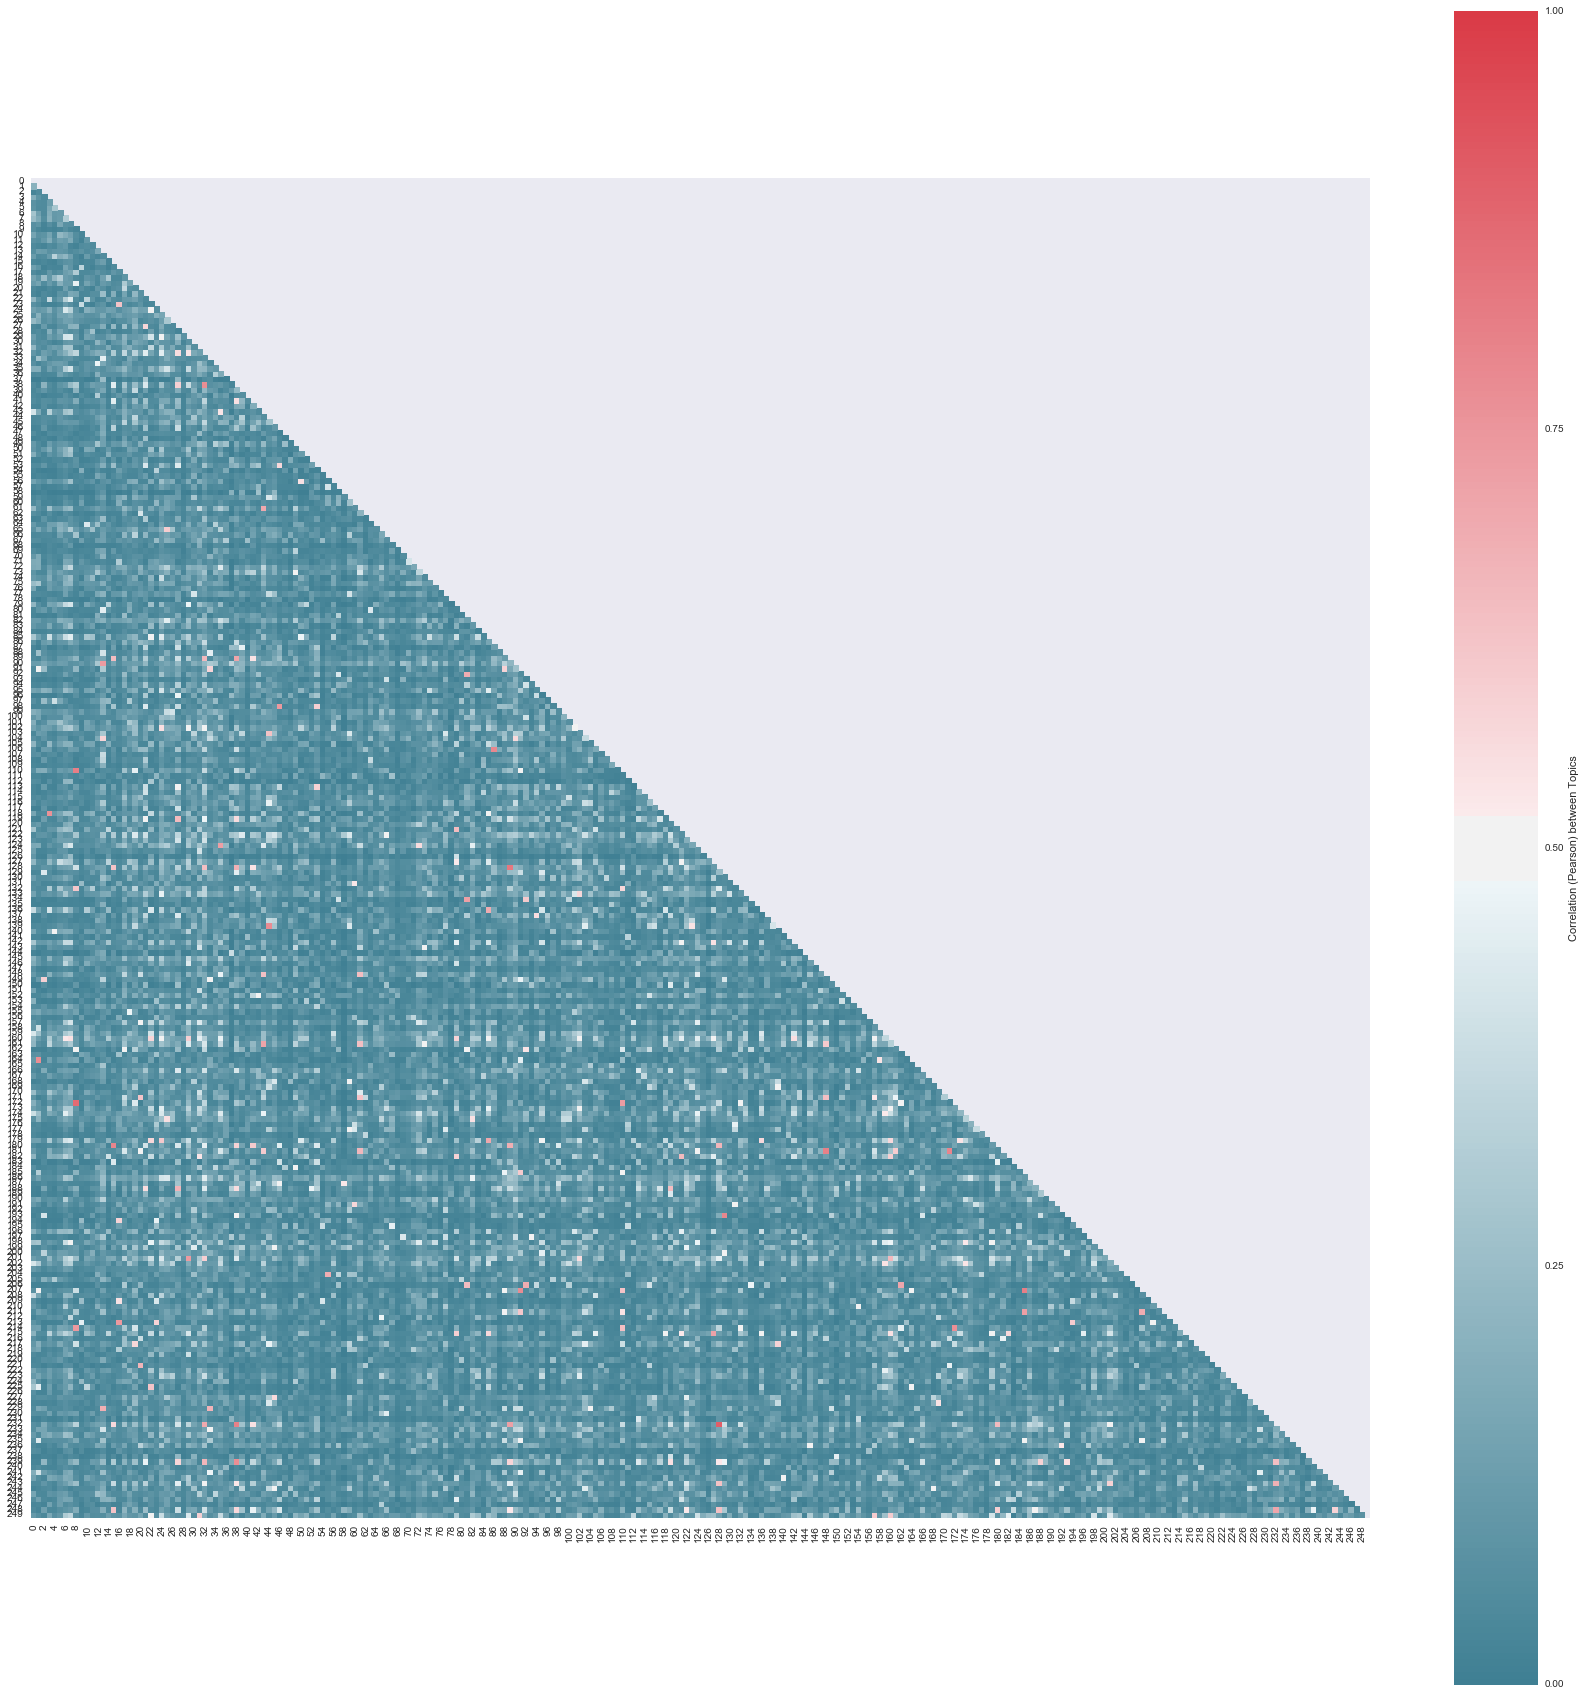

In [83]:
graph_matrix(corr250)

In [85]:
keys250 = get_topic_keys(os.path.join(dataDir, 'modelSet_for_Mallet.1918.topicKeys.txt')).drop('overallWeight', axis=1)

In [86]:
merge_frames(get_top_pairs(corr250, 50), keys250)

,topic_1,topic_2,correlation,topic_x,topic_words_x,topic_y,topic_words_y
0,128,232,0.900675,128,meeting sabbath tent truth place bro good chur...,232,meeting church sabbath bro truth lord held goo...
1,8,172,0.870893,8,sabbath seventh week commandment sunday lord f...,172,sabbath lord seventh rest holy man rested crea...
2,89,128,0.831626,89,meeting tent brother church sabbath city elder...,128,meeting sabbath tent truth place bro good chur...
3,185,207,0.810849,185,sunday law city business police sabbath open c...,207,sunday law sabbath rest right religious state ...
4,8,110,0.810247,8,sabbath seventh week commandment sunday lord f...,110,sabbath sunday church change lord seventh obse...
5,38,232,0.807938,38,brother church meeting sabbath elder sister he...,232,meeting church sabbath bro truth lord held goo...
6,148,181,0.807892,148,said girl little aunt mother know miss think l...,181,little said mother boy child think mamma know ...
7,15,180,0.793416,15,meeting camp tent attend ground held conferenc...,180,meeting conference camp elder held brother sab...
8,171,181,0.793249,171,little mother child face said father eye girl ...,181,little said mother boy child think mamma know ...
9,129,193,0.789567,129,church christian baptist minister methodist re...,193,church member organization elder order body mi...


## With 200 Topics

In [112]:
dataSetName = 'target_300_10.896.t.200'

In [116]:
params200 = extract_params(os.path.join(dataDir, '{}.state.gz'.format(dataSetName)))

In [117]:
model200 = state_to_df(os.path.join(dataDir, '{}.state.gz'.format(dataSetName)))
wt200 = model200[['type', 'topic']]

In [118]:
corr200 = pivot_and_smooth(aggregate_data(wt200), params200[1]).corr()

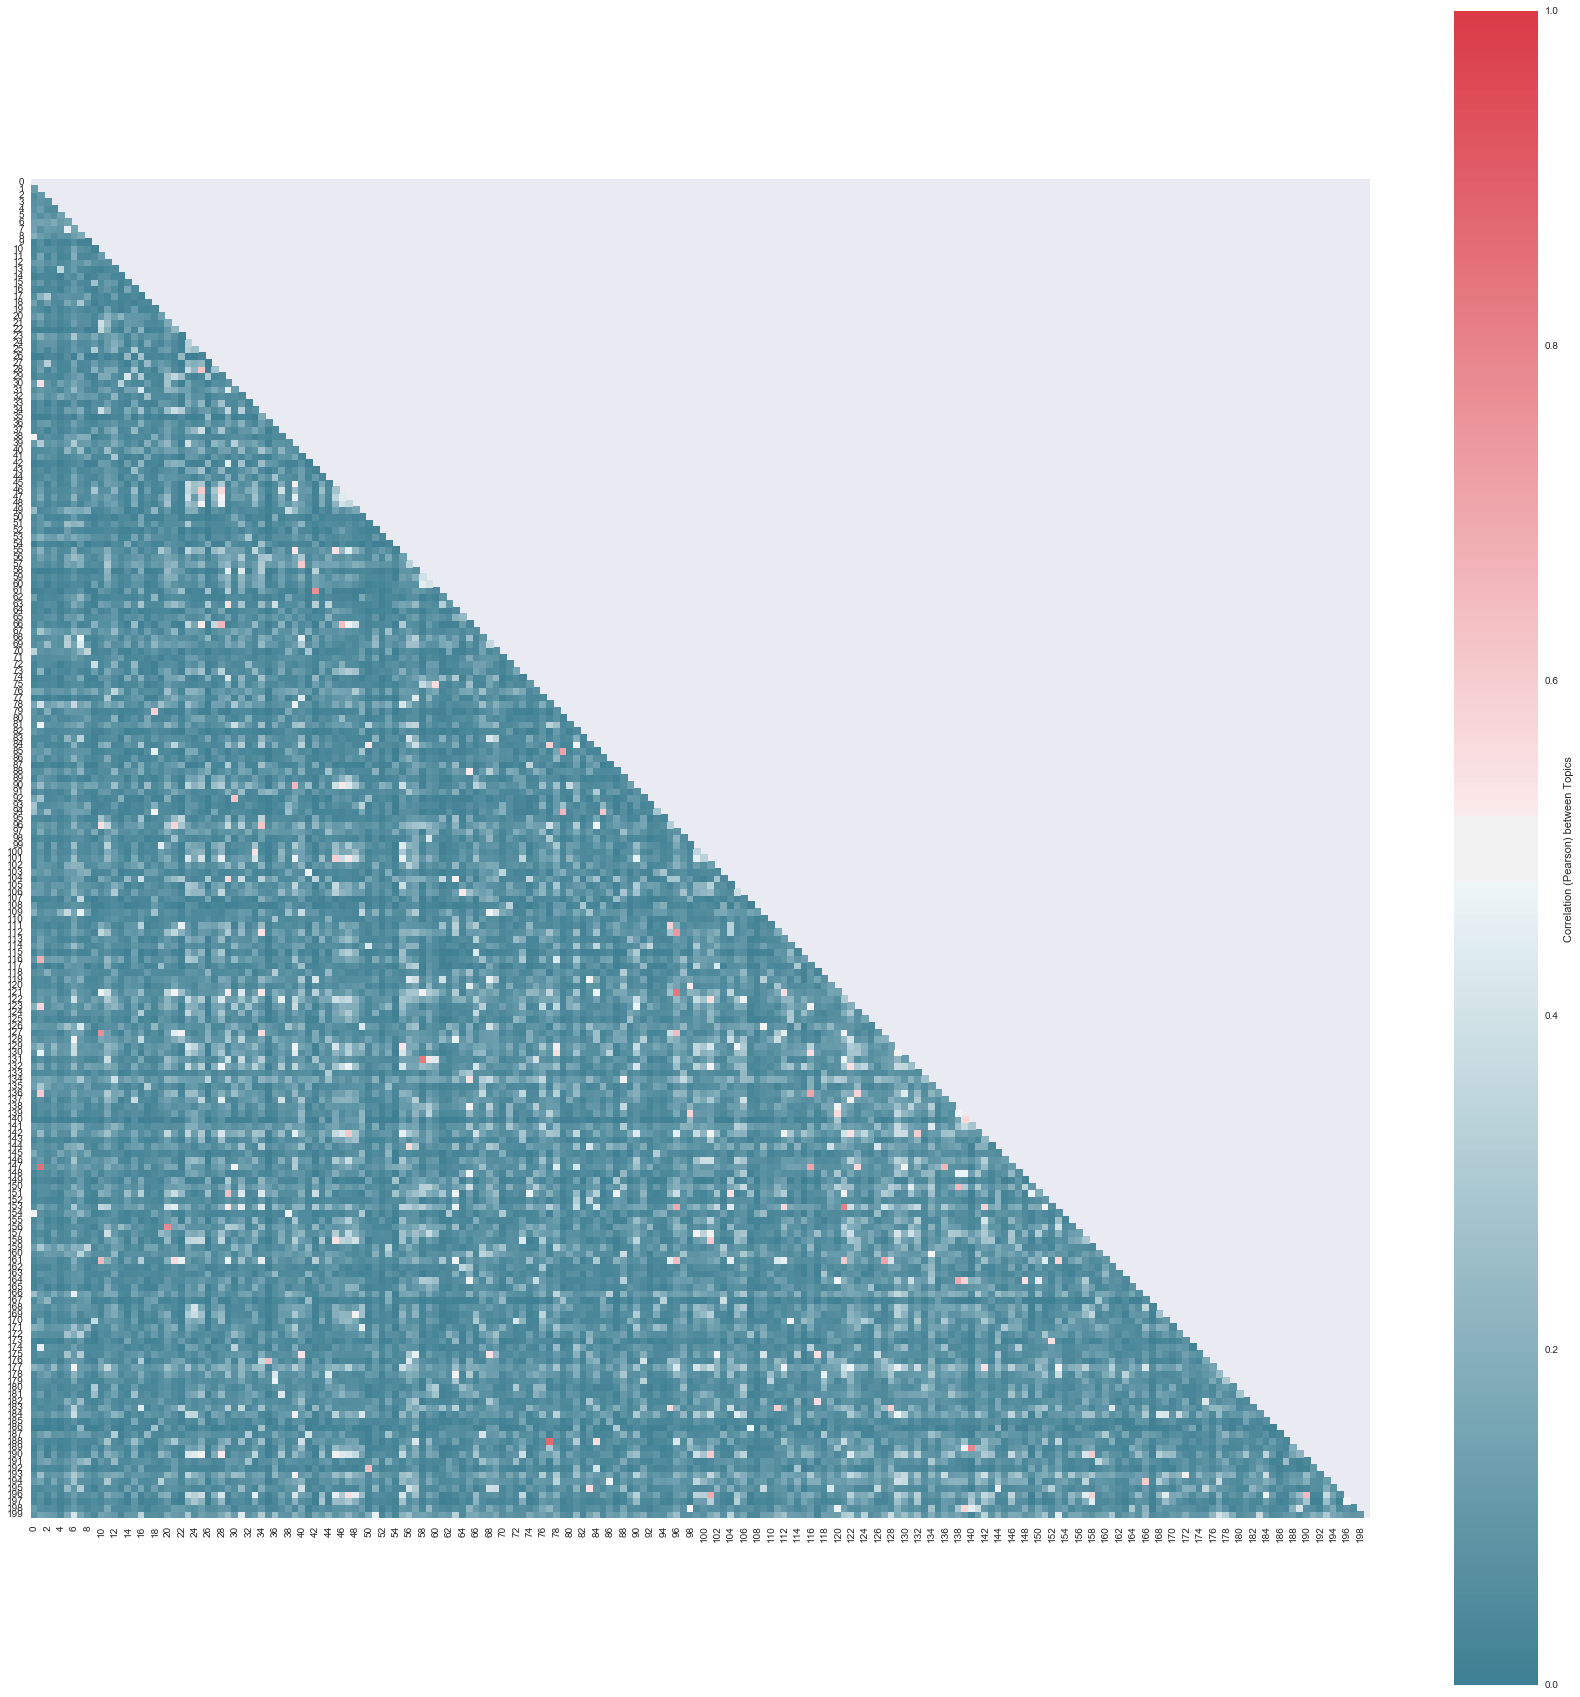

In [119]:
graph_matrix(corr200)

In [120]:
keys200 = get_topic_keys(os.path.join(dataDir, '{}.topicKeys.txt'.format(dataSetName))).drop('overallWeight', axis=1)

In [121]:
merge_frames(get_top_pairs(corr200, 50), keys200)

,topic_1,topic_2,correlation,topic_x,topic_words_x,topic_y,topic_words_y
0,77,188,0.869461,77,sabbath seventh lord commandment holy sunday r...,188,sabbath week seventh lord christ sunday rest r...
1,1,147,0.851366,1,little said mother boy child baby think know l...,147,said little mother girl know think aunt miss d...
2,96,121,0.835659,96,meeting sabbath church bro truth good lord pla...,121,church meeting sabbath truth brother held plac...
3,58,131,0.830133,58,church member elder organization order ministe...,131,church christian minister religion methodist w...
4,121,153,0.811102,121,church meeting sabbath truth brother held plac...,153,brother lord church sabbath meeting sister tru...
5,140,189,0.793420,140,law sin christ death man faith righteousness r...,189,law commandment shall christ sabbath said prec...
6,20,156,0.782252,20,died aged month sister church death writer bro...,156,born died sister church brother child adventis...
7,10,127,0.766991,10,meeting tent camp july camp_meeting june groun...,127,meeting camp state sept held conference attend...
8,42,61,0.766037,42,california church elder cal san conference oak...,61,california cal conference elder southern mount...
9,96,112,0.745320,96,meeting sabbath church bro truth good lord pla...,112,bro brother meeting sabbath white truth lord c...
